# This script prepares prior for the coming simulation study or EDA analysis. 

### Stage I: interpolate data for the area inside the operational area using SINMOD. 

In [1]:
from src.WGS import WGS
import os
import netCDF4
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point

filepath = "/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples/samples_2022.05.11.nc"
path_border = "src/csv/polygon_border.csv"
path_obstacle = "src/csv/polygon_obstacle.csv"

sinmod = netCDF4.Dataset(filepath)
plg_border = pd.read_csv(path_border).to_numpy()
plg_obstacle = pd.read_csv(path_obstacle).to_numpy()
plg_b_sh = Polygon(plg_border)
plg_o_sh = Polygon(plg_obstacle)

timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])
salinity = np.array(sinmod['salinity'])

sal = np.nanmean(salinity[:, 0, :, :], axis=0)
lat = lat.flatten()
lon = lon.flatten()
sal = sal.flatten()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
plt.scatter(lon, lat, c=sal, cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
plt.plot(plg_border[:, 1], plg_border[:, 0], 'r-.')
plt.plot(plg_obstacle[:, 1], plg_obstacle[:, 0], 'r-.')
plt.colorbar()

In [ ]:
def border_contains(loc: np.ndarray) -> bool:
    """ Test if point is within the border polygon """
    lat, lon = loc
    point = Point(lat, lon)
    return plg_b_sh.contains(point)

def obstacle_contains(loc: np.ndarray) -> bool: 
    lat, lon = loc
    point = Point(lat, lon)
    return plg_o_sh.contains(point)

def get_legal_indices(lat, lon) -> np.ndarray: 
    ind = []
    for i in range(len(lat)):
        loc = np.array([lat[i], lon[i]])
        if border_contains(loc) and not obstacle_contains(loc):
            ind.append(True)
        else: 
            ind.append(False)
    return ind

In [ ]:
ind_legal = get_legal_indices(lat, lon)

In [ ]:
plt.scatter(lon[ind_legal], lat[ind_legal], c=sal[ind_legal], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)

In [ ]:
lat_l = lat[ind_legal]
lon_l = lon[ind_legal]
sal_l = sal[ind_legal]
x, y = WGS.latlon2xy(lat_l, lon_l)
dataset = np.stack((x, y, sal_l), axis=1)
df = pd.DataFrame(dataset, columns=['x', 'y', 'salinity'])
df.to_csv("prior/sinmod.csv", index=False)


# Section II: extract SINMOD surface salinity for visualizing in the paper.
- Remember to remove nan values so only valid values will be put on the map

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.animation import FuncAnimation

timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])
salinity = np.array(sinmod['salinity'])

""" Extract legal indices. """
mask_value = -32768.0
lat_f = lat.flatten()
lon_f = lon.flatten()
sal_f = np.mean(salinity[:, 0, :, :], axis=0).flatten()
ind_legal = np.where(~(sal_f == mask_value))[0]

beta0 = 0.26095833
beta1 = 0.99898364
threshold = 26.81189868
sal_f = sal_f * beta1 + beta0

# plt.figure()
# plt.scatter(lon, lat, c=np.mean(salinity[:, 0, :, :], axis=0), cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
# plt.colorbar()
# plt.savefig("/Users/yaolin/Downloads/fig/S_{:03d}.png".format(i))

dataset = np.stack((lat_f[ind_legal], lon_f[ind_legal], sal_f[ind_legal]), axis=1)
df = pd.DataFrame(dataset, columns=['lat', 'lon', 'salinity'])
df.to_csv("/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Projects/GOOGLE/Docs/GIS/csv/sinmod_adjusted.csv", index=False)

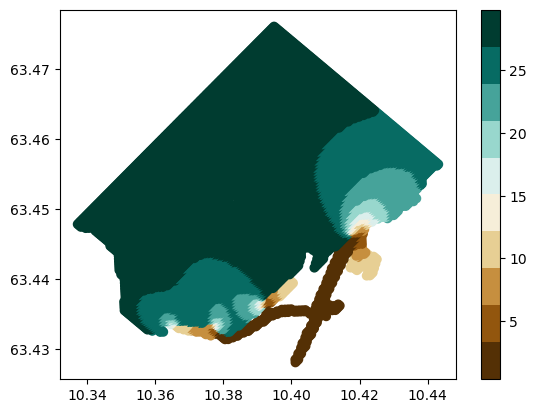

In [4]:
plt.scatter(df['lon'], df['lat'], c=df['salinity'], cmap=get_cmap("BrBG", 10))
plt.colorbar()
# for i in tqdm(range(salinity.shape[0])):
#     plt.figure()
#     plt.scatter(lon, lat, c=salinity[i, 0, :, :], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
#     plt.colorbar()
#     plt.savefig("/Users/yaolin/Downloads/fig/S_{:03d}.png".format(i))
#     plt.close("all")
#     plt.show()

# Section III: create SINMOD data region for masking out values in visulization. 

In [32]:
box = np.array([[63.4441527, 10.3296626],
                [63.4761121, 10.3948786],
                [63.4528538, 10.45186239],
                [63.4209213, 10.38662725]])
df = pd.DataFrame(box, columns=['lat', 'lon'])
df.to_csv("/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Projects/GOOGLE/Docs/GIS/csv/sinmod_region.csv", index=False)

# Section IV, precalculate bivariate cumulative density function for z1, z2 and correlation coefficient. 

In [21]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt



In [44]:

z1 = np.arange(-5, 5, .1)
z2 = np.arange(-5, 5, .1)


cdf_table = dict()
cdf = np.zeros([len(z1), len(z2)])
for i in range(z1.shape[0]): 
    cdf_table[z1[i]] = dict()
    for j in range(z2.shape[0]):
        cdf[i, j] = multivariate_normal.cdf([z1[i], z2[j]], mean=[0, 0], cov=[[1, 0], [0, 1]])
        cdf_table[z1[i]][z2[j]] = cdf[i, j]




{-5.0: {-5.0: 8.216912366834558e-14,
  -4.9: 1.3735863946364542e-13,
  -4.800000000000001: 2.2740876179545934e-13,
  -4.700000000000001: 3.728785014004408e-13,
  -4.600000000000001: 6.05538461029914e-13,
  -4.500000000000002: 9.739483419863059e-13,
  -4.400000000000002: 1.5515142190852007e-12,
  -4.3000000000000025: 2.4479773270763404e-12,
  -4.200000000000003: 3.825579933493155e-12,
  -4.100000000000003: 5.921506827859296e-12,
  -4.0000000000000036: 9.0786112552448e-12,
  -3.900000000000004: 1.3786892614916716e-11,
  -3.8000000000000043: 2.0738680514465785e-11,
  -3.7000000000000046: 3.090096305086132e-11,
  -3.600000000000005: 4.560872747022328e-11,
  -3.5000000000000053: 6.668349117339315e-11,
  -3.4000000000000057: 9.658130362280328e-11,
  -3.300000000000006: 1.3857429030501068e-10,
  -3.2000000000000064: 1.969691700104338e-10,
  -3.1000000000000068: 2.77364982037114e-10,
  -3.000000000000007: 3.8695039266113053e-10,
  -2.9000000000000075: 5.348383154126993e-10,
  -2.80000000000000

In [30]:
cdf_table

{(-5.0, -5.0): 8.216912366834558e-14,
 (-5.0, -4.898989898989899): 1.3806658375181413e-13,
 (-5.0, -4.797979797979798): 2.2971388338675475e-13,
 (-5.0, -4.696969696969697): 3.784511750153364e-13,
 (-5.0, -4.595959595959596): 6.17393268448436e-13,
 (-5.0, -4.494949494949495): 9.973534273022118e-13,
 (-5.0, -4.393939393939394): 1.5954289927752325e-12,
 (-5.0, -4.292929292929293): 2.527280394935702e-12,
 (-5.0, -4.191919191919192): 3.964456118702514e-12,
 (-5.0, -4.090909090909091): 6.158501923655223e-12,
 (-5.0, -3.9898989898989896): 9.474040741121406e-12,
 (-5.0, -3.888888888888889): 1.443350945204395e-11,
 (-5.0, -3.787878787878788): 2.177676775357539e-11,
 (-5.0, -3.686868686868687): 3.253931495549908e-11,
 (-5.0, -3.5858585858585856): 4.815330682408114e-11,
 (-5.0, -3.484848484848485): 7.057587976152779e-11,
 (-5.0, -3.383838383838384): 1.0244936541850214e-10,
 (-5.0, -3.282828282828283): 1.4729769732219784e-10,
 (-5.0, -3.1818181818181817): 2.097625398748561e-10,
 (-5.0, -3.08080808